In [1]:
suppressPackageStartupMessages(
    {suppressWarnings({
        library(tidyverse)
        library(repr)
        library(tidymodels)
        library(tidyr)
        library(ggplot2)        
        library(scales)
        library(patchwork) 
        library(purrr)
        library(dplyr)
    })
})

In [2]:
# Size and general style set up
options(repr.plot.width = 6, repr.plot.height = 4, repr.matrix.max.rows = 7,readr.show_col_types = FALSE)

# Load Data
player_data <- read_csv("https://raw.githubusercontent.com/FabianoGLentini/player-subscription-ml/refs/heads/main/data/players.csv")


# Data Science Project: Project Final Report


## Introduction:

## Methods & Results:

### Set up and intro to data: "TODO should rename later." 

In [3]:
# Wrangle data
#TODO will need additional wranggling due to poor or few varied sample categories
player_df <- player_data |> # TODO must consider reworking a joining of some labels in gender etc due to low representaions
            select( subscribe, gender, played_hours, experience, Age) |>
            drop_na() |>
            mutate(
                subscribe = as_factor(subscribe),  # lgl -> fct for analysis and modeling
                gender = as_factor(gender),        # chr -> fct for analysis and modeling
                played = factor(as.logical(played_hours)), # TODO may not use 
                experience = as_factor(experience) # chr -> fct for analysis and modeling
            ) |>
             mutate(gender = fct_recode(gender, # Aggregate some of the gender to balance out count and avoid missclassification due to underepresented categories
                                    "Non-binary/Other" = "Agender",
                                    "Non-binary/Other" = "Non-binary",
                                     "Non-binary/Other" = "Two-Spirited",
                                    "Non-binary/Other" = "Other"
                                      ))
 # Removed row with NA values, as it may distort the model      

# TODO FABIO check if player_hours should adjust to use a binary outcome, 
# either played or didn't play at all, or if any of the predictor should be removed.


Warning message:
“There was 1 warning in `mutate()`.
ℹ In argument: `gender = fct_recode(...)`.
Caused by warning:
! Unknown levels in `f`: Other”


### Training and Analysis:

In [4]:
# head(player_df) # TODO DELETE tmp  for set up 

In [5]:
set.seed(2025) # Don't change
# Prep for modelling
ply_df <- select(player_df, Age, subscribe, gender, played_hours)  # Exclude row_id & experience for modeling purposes

# Split step
player_split <- initial_split(ply_df, prop = 0.70, strata = subscribe) 
player_train <- training(player_split)
player_test <- testing(player_split)

# TODO FABIO CHECK boostraps() and if it would benefit our model with our small set

In [6]:
#TODO FABIO write up split/scale/recipe step reasoning
# 'initial split' Use Strata sub to balance the outcome for the bool prediction to avoid 
# imbalance in our test and train data split

# ... why use 75 25 split instead of 70/30 etc?

# ~ maybe explain why start with all predictors

In [7]:
#TODO FABIO ... search refractor options to reduce code clutter

# Recipes:
# Scale/Recipe

# Note: A = Age, G = gender and H = played_hours
# Recipe 01:
# Age + gender + played_hours
rc_AGH <- recipe(subscribe ~ Age + gender + played_hours, data = player_train) |>
            step_dummy(all_nominal_predictors()) |>
            step_zv(all_predictors()) |> # Used to remove zero-variance variable after wrangling, gender_Other category had no rows associated to i 
            step_normalize(all_numeric_predictors())
# # Recipe 02:
# Age + played_hours
rc_AH <- recipe(subscribe ~ Age + played_hours, player_train) |>
            step_dummy(all_nominal_predictors()) |>
            step_zv(all_predictors()) |> # Used to remove zero-variance variable after wrangling, gender_Other category had no rows associated to i 
            step_normalize(all_numeric_predictors())

# Recipe 03:
# Age + gender 
rc_AG <- recipe(subscribe ~ Age + gender, player_train) |>
            step_dummy(all_nominal_predictors()) |>
            step_zv(all_predictors()) |> # Used to remove zero-variance variable after wrangling, gender_Other category had no rows associated to i 
            step_normalize(all_numeric_predictors())

# Recipe 04:
# gender + played_hours
rc_GH <- recipe(subscribe ~ gender + played_hours, player_train) |>
            step_dummy(all_nominal_predictors()) |>
            step_zv(all_predictors()) |> # Used to remove zero-variance variable after wrangling, gender_Other category had no rows associated to i 
            step_normalize(all_numeric_predictors())

# Recipe 05:
# Age
rc_A <- recipe(subscribe ~ Age, player_train) |>
            step_dummy(all_nominal_predictors()) |>
            step_zv(all_predictors()) |> # Used to remove zero-variance variable after wrangling, gender_Other category had no rows associated to i 
            step_normalize(all_numeric_predictors())

# Recipe 06:
# gender
rc_G <- recipe(subscribe ~ gender, player_train) |>
            step_dummy(all_nominal_predictors()) |>
            step_zv(all_predictors()) |> # Used to remove zero-variance variable after wrangling, gender_Other category had no rows associated to i 
            step_normalize(all_numeric_predictors())

# Recipe 07:
# played_hours
rc_H <- recipe(subscribe ~ played_hours, player_train) |>
            step_dummy(all_nominal_predictors()) |>
            step_zv(all_predictors()) |> # Used to remove zero-variance variable after wrangling, gender_Other category had no rows associated to i 
            step_normalize(all_numeric_predictors())



In [8]:
#TODO FABIO breackdown hypothesis for each recipe variation ...?

In [9]:
# Spec set up
knn_tune <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
            set_engine("kknn") |>
            set_mode("classification")

#TODO FABIO ... search refractor options to reduce code clutter
# Check mean and standard error through collect_metrics


In [10]:
# TODO FABIO ~ write up spec use and impl of vfold..?

In [11]:
# TODO FABIO confirm that not having set.seed here is fine as long as set.seed above code cell goes first
# K-fold cross-validation
set.seed(1234) # Don't change
kfolds <- vfold_cv(player_train, v = 5, strata = subscribe)
k_vals = tibble(neighbors = seq(from = 1, to = 10, by = 1))


In [12]:
#TODO FABIO write reasonin + graph to show fold outcome
#Note the reason of using 10 10-fold is due to the small size data,
#hence it will improve the estimate and 

In [13]:
# Simplifying multi-model testing: https://www.youtube.com/watch?v=YZqbOATpjM4&t=139s
# Workflow Step
workflow_set <- workflow_set(
    preproc = list(
        AGH = rc_AGH,
        AH = rc_AH,
        AG = rc_AG,
        GH = rc_GH,
        A = rc_A,
        G = rc_G,
        H = rc_H
    ),
    models = list(knn_tune),
    cross = TRUE
)

# Tune workflow
# set.seed(22)

knn_tuned_set <- workflow_map(
    workflow_set,
    "tune_grid",
    resamples = kfolds,
    grid = k_vals,
    seed = 22
)


In [14]:
#TODO FABIO write workflow step use case/what it functionally is doing 

In [15]:

options(repr.plot.width = 15, repr.plot.height = 5)
# Get metrics all in one
all_metrics_collected <- workflow_map(
    knn_tuned_set,
    metrics = metric_set(accuracy, recall, precision)
) 

all_metrics_collected_res <- collect_metrics(all_metrics_collected)

→ A | warning: While computing binary `precision()`, no predicted events were detected (i.e.
               `true_positive + false_positive = 0`).
               Precision is undefined in this case, and `NA` will be returned.
               Note that 7 true event(s) actually occurred for the problematic event level,
               FALSE

There were issues with some computations   A: x1

There were issues with some computations   A: x2

There were issues with some computations   A: x2



→ A | warning: While computing binary `precision()`, no predicted events were detected (i.e.
               `true_positive + false_positive = 0`).
               Precision is undefined in this case, and `NA` will be returned.
               Note that 7 true event(s) actually occurred for the problematic event level,
               FALSE

There were issues with some computations   A: x1

There were issues with some computations   A: x1





In [16]:
# all_metrics_collected_res
#TODO TMP trying to regain neighbours
res_All_met_tuned <- all_metrics_collected |>
            rowwise() |>
            mutate(metrics = list(collect_metrics(result)),
                  wflow_id = fct_recode(wflow_id,
                      "Age, gender and played hours" = "AGH_nearest_neighbor",
                      "Gender and played hours" = "GH_nearest_neighbor",
                      "Gender" = "G_nearest_neighbor",
                      "Age and gender" = "AG_nearest_neighbor",
                      "Age and played hours" = "AH_nearest_neighbor",
                      "Age" = "A_nearest_neighbor",
                      "Played hours" = "H_nearest_neighbor",
                  )) |>
            unnest(metrics) |>
            select(wflow_id, .metric, mean, neighbors, std_err) |>
            arrange(desc(mean))
# ADD RANKING
ranked_met <- res_All_met_tuned |>
            mutate(rank = seq(1, nrow(res_All_met_tuned), 1))
# ranked_met
# Visualize result
options(repr.plot.width = 8, repr.plot.height = 5)

plot_met_tmp <- ggplot(ranked_met, aes(x = rank, y = mean, color = wflow_id)) +
                geom_point() +
                ylim(c(0,1)) + 
                labs(x = "Ranke by metric mean", y = "Metric mean percentage", color = "Predictor Combinations") 

# plot_met_tmp


Warning message:
“There were 7 warnings in `mutate()`.
The first warning was:
ℹ In argument: `wflow_id = fct_recode(...)`.
ℹ In row 1.
Caused by warning:
! Unknown levels in `f`: GH_nearest_neighbor, G_nearest_neighbor, AG_nearest_neighbor, AH_nearest_neighbor, A_nearest_neighbor, H_nearest_neighbor
ℹ Run `dplyr::last_dplyr_warnings()` to see the 6 remaining warnings.”


In [17]:
# METRIC set up
# Accuracy
acc_met <- res_All_met_tuned |>
            filter(.metric ==  "accuracy")
acc_met_rank <- mutate(acc_met, rank = seq(1, nrow(acc_met), 1))
acc_met_plot <- plot_met_tmp %+% acc_met_rank +
                ggtitle("Ranked by Accuracy Mean")



# Precision
prec_met <- res_All_met_tuned |>
            filter(.metric ==  "precision")
prec_met_rank <- mutate(prec_met, rank = seq(1, nrow(prec_met), 1))
prec_met_plot <- plot_met_tmp %+% prec_met_rank +
                ggtitle("Ranked by Precision Mean")



# Recall
rec_met <- res_All_met_tuned |>
            filter(.metric ==  "recall")
rec_met_rank <- mutate(rec_met, rank = seq(1, nrow(rec_met), 1))
rec_met_plot <- plot_met_tmp %+% rec_met_rank +
                ggtitle("Ranked by Recall Mean")



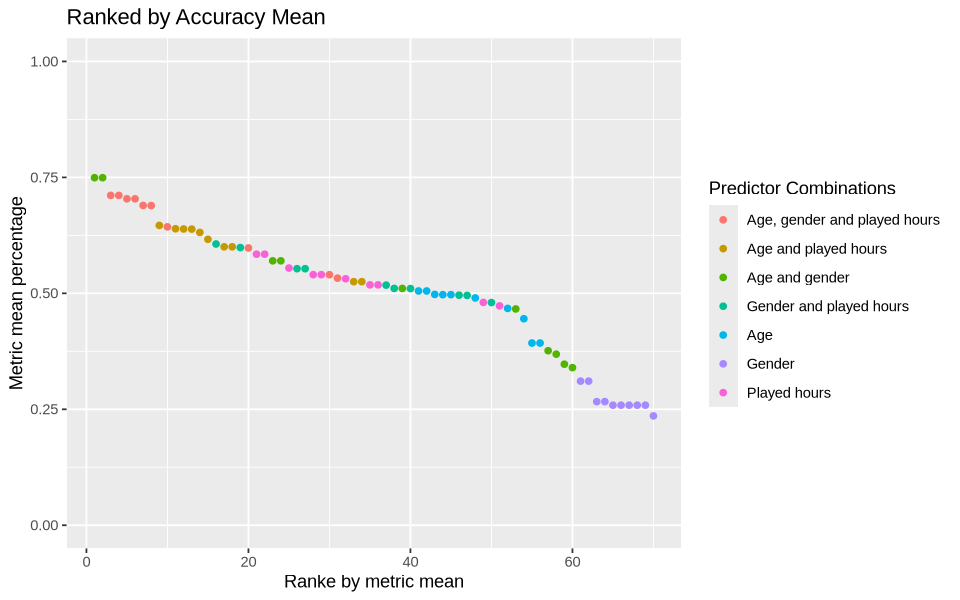

In [18]:
# Accuracy tuned metric plot
acc_met_plot

In [19]:
#TODO write about the result acc

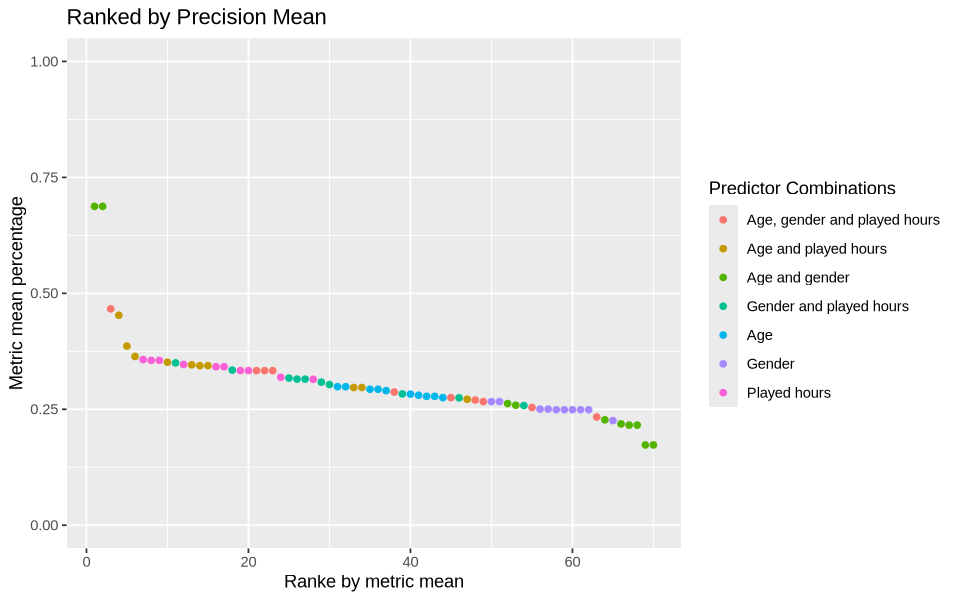

In [20]:
# Accuracy tuned metric prec
prec_met_plot

In [21]:
#TODO write about the result prec

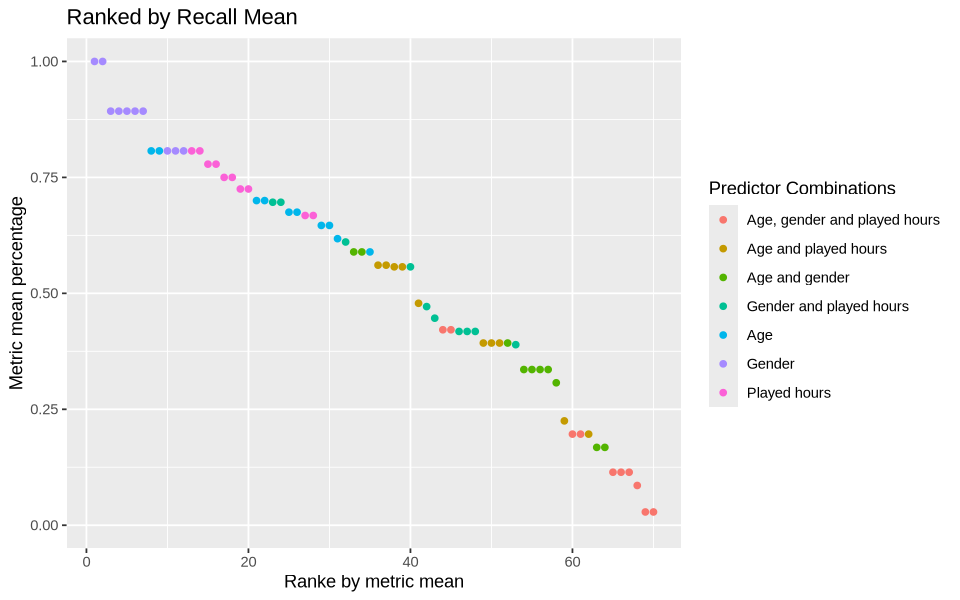

In [22]:
# Accuracy tuned metric rec
rec_met_plot

In [23]:
#TODO write about the result rec

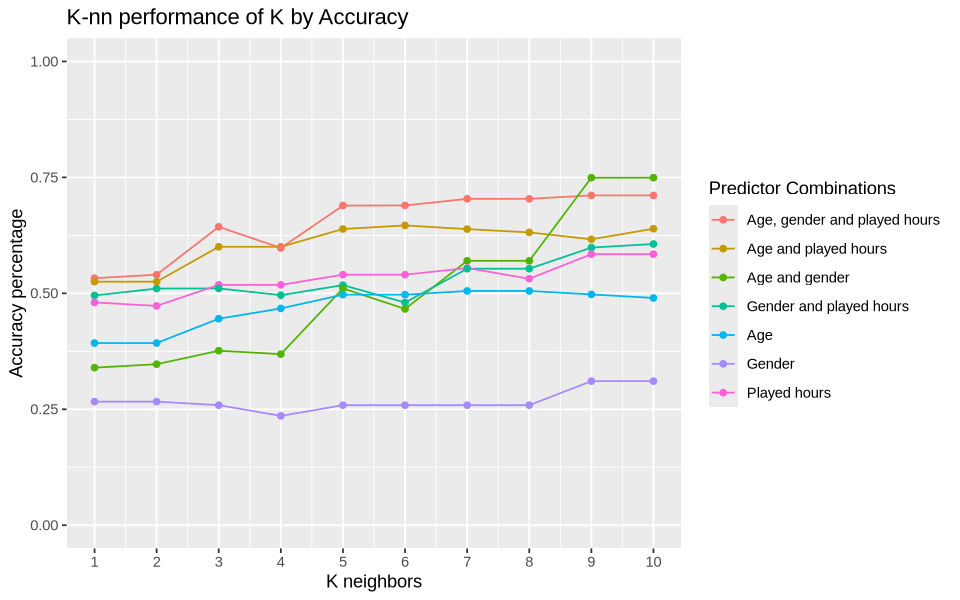

In [24]:
# LINE Graph showing k performance for each recipe
overlapped_line_acc <- ggplot(acc_met, aes(x = neighbors, y = mean, color = wflow_id)) +
                        geom_line() +
                        geom_point() + 
                        ylim(c(0, 1)) + 
                        scale_x_continuous(breaks = seq(0,10,1)) +
                        labs(
                            x = "K neighbors", 
                            y = "Accuracy percentage",  
                            color = "Predictor Combinations",
                        )  +
                        ggtitle("K-nn performance of K by Accuracy")
                        

overlapped_line_acc

In [25]:
#TODO FABIO discuss on concerns for high k doing so well, should concider reducing k for some options maybe?

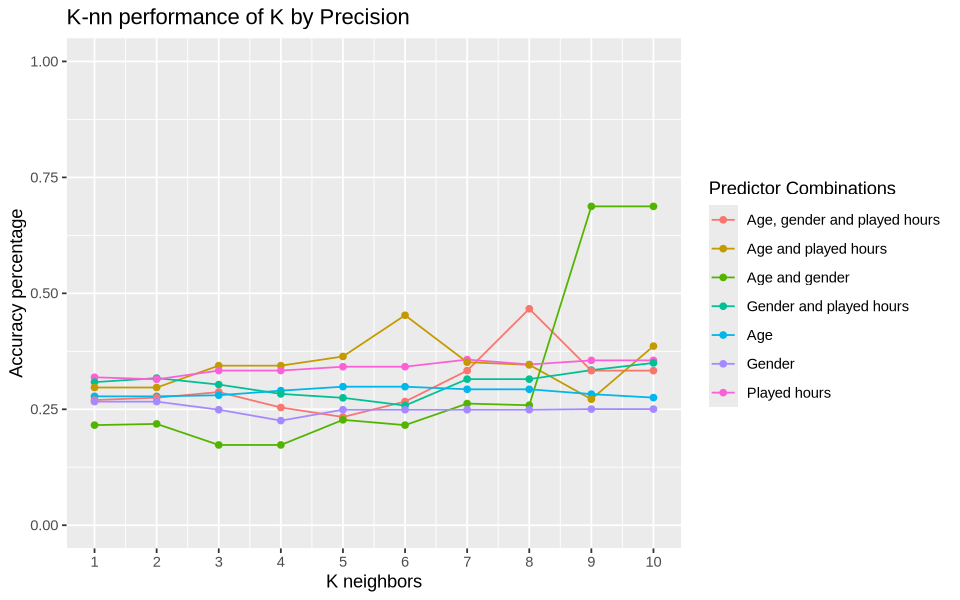

In [26]:
# LINE Graph showing k performance for each recipe Using precision
overlapped_line_prec <- overlapped_line_acc %+% prec_met +
                        ggtitle("K-nn performance of K by Precision")
overlapped_line_prec

In [27]:
#TODO FABIO discuss on concerns for high k doing so well, should concider reducing k for some options maybe?
# Precission

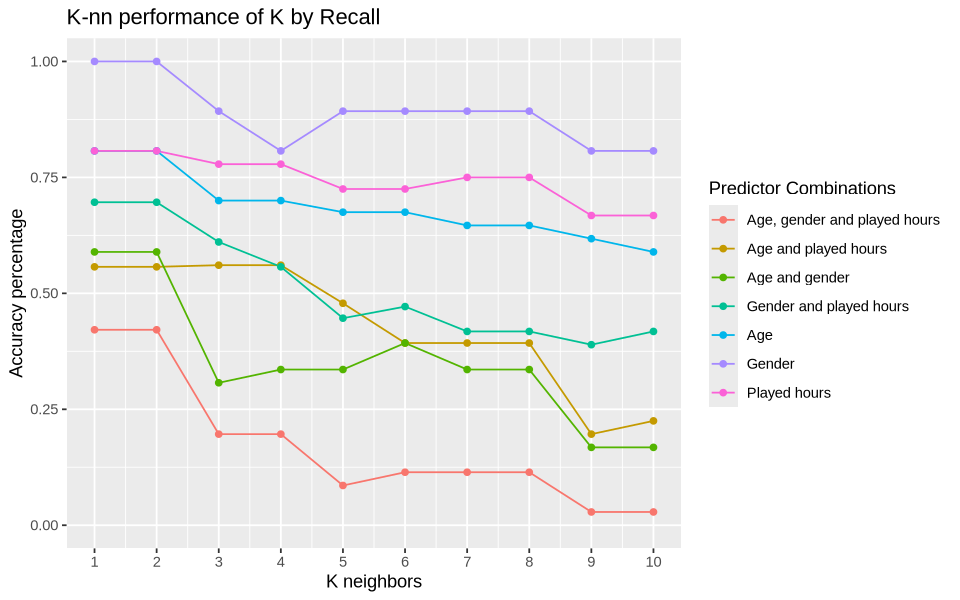

In [28]:
# LINE Graph showing k performance for each recipe Using precision
overlapped_line_rec <- overlapped_line_acc %+% rec_met +
                        ggtitle("K-nn performance of K by Recall")
overlapped_line_rec

In [29]:
#TODO FABIO discuss concerns for high k doing so well, should consider reducing k for some options maybe?
# Recall

In [30]:
# FIT MODEL:
# slice(ten_acc_rank_result, 1)
# head(ten_acc_rank_result)
# final_fit <- extract_workflow(all_metrics_collected, id = "AGH_nearest_neighbor")

# # library(vip)

# final_fit |>
#     extract_fit_parsnip() |>
#     vip(geom = "col")

### Player Type Exploration: "TODO may need renaming"

## Discussion:

### Reference 

##### Data Science programming techniques and approaches:
- **Clustering prediction:** https://www.youtube.com/watch?v=z57i2GVcdww
- **Simplifying multi-model set up + testing:** https://www.youtube.com/watch?v=YZqbOATpjM4
- **Tuning and comparing models using Workflowse:** https://workflowsets.tidymodels.org/articles/tuning-and-comparing-models.html
- **Useful example of report/tutorial for tidy models:** https://optimumsportsperformance.com/blog/k-nearest-neighbor-tidymodels-tutorial/
- **Additional breakdown on workflow_set usage:** https://www.youtube.com/watch?v=R95lWUDtL5A
- **Workflow_set documentation on results:** https://workflowsets.tidymodels.org/reference/collect_metrics.workflow_set
- **Workflow_set tunning and comparing documentation:** https://workflowsets.tidymodels.org/articles/tuning-and-comparing-models

In [31]:
#TODO tmp info grounds
?case_when

case_when {dplyr},R Documentation
...,"<dynamic-dots> A sequence of two-sided formulas. The left hand side (LHS) determines which values match this case. The right hand side (RHS) provides the replacement value. The LHS inputs must evaluate to logical vectors. The RHS inputs will be coerced to their common type. All inputs will be recycled to their common size. That said, we encourage all LHS inputs to be the same size. Recycling is mainly useful for RHS inputs, where you might supply a size 1 input that will be recycled to the size of the LHS inputs. NULL inputs are ignored."
.default,"The value used when all of the LHS inputs return either FALSE or NA. .default must be size 1 or the same size as the common size computed from .... .default participates in the computation of the common type with the RHS inputs. NA values in the LHS conditions are treated like FALSE, meaning that the result at those locations will be assigned the .default value. To handle missing values in the conditions differently, you must explicitly catch them with another condition before they fall through to the .default. This typically involves some variation of is.na(x) ~ value tailored to your usage of case_when(). If NULL, the default, a missing value will be used."
.ptype,"An optional prototype declaring the desired output type. If supplied, this overrides the common type of the RHS inputs."
.size,"An optional size declaring the desired output size. If supplied, this overrides the common size computed from ...."
